## Kernel to load: vax_inc_general 

In [1]:
import pandas as pd
import numpy as np
import pycountry
import pickle
from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import math
import jenkspy
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import make_interp_spline
import os

In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
df=pd.read_csv('Supplementary Spreadsheet- Vaccination Coverage Estimates.csv')
df_incidence= pd.read_csv(os.path.join(notebook_dir, 'Disease Incidence/Supplementary Spreadsheet- Incidence Estimates.csv'))
df["Vaccination Coverage (%)"] = df["Vaccination Coverage (%)"].clip(upper=100)
df["Vaccination Coverage (%) Upper"] = df["Vaccination Coverage (%) Upper"].clip(upper=100)

# Duplicating 'newcastle disease (velogenic)' and assigning as 'newcastle disease' (for easy comparison)
   # between the vaccination coverage dataframe and incidence dataframe for newcastle disease if desired 
mask = df_incidence['Disease'].str.contains('castle', case=False, na=False)

dup_rows = df_incidence.loc[mask].copy()

#Changing the "Disease" column in the duplicated rows to "Newcastle disease"
dup_rows['Disease'] = 'Newcastle disease'

# Appending the duplicated rows to df_incidence
df_incidence = pd.concat([df_incidence, dup_rows], ignore_index=True)


In [4]:
np.unique(df_incidence['Disease'])

array(['African swine fever virus (Inf. with)', 'Anthrax',
       'Atrophic rhinitis of swine (-2005)',
       "Aujeszky's disease virus (Inf. with)", 'Avian chlamydiosis',
       'Avian infectious bronchitis',
       'Avian infectious laryngotracheitis', 'Avian tuberculosis (-2005)',
       'Bluetongue virus (Inf. with)', 'Bovine anaplasmosis',
       'Bovine babesiosis', 'Bovine cysticercosis (-2014)',
       'Bovine genital campylobacteriosis',
       'Bovine spongiform encephalopathy', 'Bovine tuberculosis (-2018)',
       'Bovine viral diarrhoea (2006-)', 'Brucella abortus (Inf. with)',
       'Brucella melitensis (Inf. with)', 'Brucella suis (Inf. with)',
       'Burkholderia mallei (Inf. with) (Glanders)',
       'Chlamydia abortus (Inf. with) (Enzootic abortion of ewes, ovine chlamydiosis)',
       'Classical swine fever virus (Inf. with)', 'Contagious agalactia',
       'Contagious caprine pleuropneumonia',
       'Crimean Congo haemorrhagic fever (2006-)',
       'Dermatophil

In [6]:
df=df.merge(df_incidence.drop(columns=['Country']),on=['ISO3','Year','Animal','Disease'],how='outer')

In [9]:
pop_countries_cattle = df['ISO3']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_3] = country.name
    
for row in df.iterrows():
    if (row[1]['Country']==row[1]['Country']):
        countries[row[1]['ISO3']]=row[1]['Country']

codes_pop_cattle = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_cattle]

iso3s_pop_cattle=[]

for i in pop_countries_cattle:
    try:
        iso3s_pop_cattle+=[countries[i]]
    except:
        iso3s_pop_cattle+=[None]
        
df['Country']=iso3s_pop_cattle


print(np.unique(codes_pop_cattle)) 

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia, Plurinational State of' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Congo, The Democratic Republic of the' 'Cook Islands'
 'Costa Rica' 'Croatia' 'Cuba' 'Curaçao' 'Cyprus' 'Czechia'
 "Côte d'Ivoire" 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Eswatini' 'Ethiopia' 'Falkland Islands (Malvinas)' 'Faroe Islands'
 'Fiji' 'Finland' 'France' 'French Guiana' 'French Polynesia' 'Gabon'
 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece' 'Gr

In [10]:
df=df.sort_values(['Country','Animal','Disease'])

In [11]:
df_pop_cattle=pd.read_csv(os.path.join(source_data_path, 'cattle/cattle_pop_2024.csv'))
df_pop_cattle = df_pop_cattle.sort_values('Value').drop_duplicates(subset=['ISO3','Year','Item'], keep='last').loc[:,['Area','Value','ISO3','Year']]
df_pop_cattle=df_pop_cattle.sort_values('Year').loc[:,['Area','Value','ISO3','Year']]
df_pop_cattle['Animal']=['Cattle']*df_pop_cattle.shape[0]
df_pop_cattle.rename(columns={'Value':'latest pop'},inplace=True)

df_pop_poultry=pd.read_csv(os.path.join(source_data_path, "poultry/poultry_pop_2024.csv"))
df_pop_poultry = df_pop_poultry.sort_values('Value').drop_duplicates(subset=['ISO3','Year','Item'], keep='last')
df_pop_poultry = (
    df_pop_poultry.groupby(['ISO3', 'Year Code'], as_index=False)
    .agg({
        'Domain Code': 'first',
        'Domain': 'first',
        'Area Code (M49)': 'first',
        'Area': 'first',
        'Element Code': 'first',
        'Element': 'first',
        'Item Code (CPC)': 'first',
        'Year Code': 'first',
        'Year': 'first',
        'Unit': 'first',
        'Value': 'sum',  
        'Flag': 'first',
        'Flag Description': 'first',
        'Note': 'first',
        'ISO3':'first'
    })
)
df_pop_poultry['Item'] = 'Poultry'
df_pop_poultry=df_pop_poultry.sort_values('Year').loc[:,['Area','Value','ISO3','Year']]
df_pop_poultry.rename(columns={'Value':'latest pop'},inplace=True)
df_pop_poultry['Animal']=['Poultry']*df_pop_poultry.shape[0]
df_pop_poultry['latest pop']*=1000


df_pop_swine=pd.read_csv(os.path.join(source_data_path, 'swine/swine_pop_2024.csv'))
df_pop_swine = df_pop_swine.sort_values('Value').drop_duplicates(subset=['ISO3','Year','Item'], keep='last')
df_pop_swine.sort_values('Year').loc[:,['Area','Value','ISO3','Year']]
df_pop_swine.rename(columns={'Value':'latest pop'},inplace=True)
df_pop_swine['Animal']=['Pigs']*df_pop_swine.shape[0]

In [12]:
pop_countries_cattle = df_pop_cattle['Area']
pop_countries_poultry = df_pop_poultry['Area']
pop_countries_swine = df_pop_swine['Area']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    countries['USA']='USA'
    countries['UK']='GBR'
    countries['Taiwan']='TWN'
    countries['South Korea']='KOR'
    countries['Czech Republic']='CZE'
    countries['Brunei']='BRN'
    countries['Russia']='RUS'
    countries['IrAAan']='IRN'
    countries['United States of America']='USA'
    countries['Venezuela']='VEN'
    countries['China (Hong Kong SAR)']='HKG'
    countries["Cote d'Ivoire"]='CIV'
    countries['DR Congo']='COD'
    countries['Guinea Bissau']='GNB'
    countries['Lao PDR']='LAO'
    countries['Micronesia (Federated States of)']='FSM'
    countries['North Korea']='PRK'
    countries['Occupied Palestinian Territory']='PSE'
    countries['Swaziland']='SWZ'
    countries['Tanzania']='TZA'
    countries['Bolivia']='BOL'
    countries['Macedonia (TFYR)']='MKD'
    countries['Moldova']='MDA'
    countries['Bolivia (Plurinational State of)']='BOL'
    countries['China, Hong Kong SAR']='HKG'
    countries['China, Taiwan Province of']='TWN'
    countries['China, mainland']='CHN'
    countries['Czechoslovakia']='CSK'
    countries["Democratic People's Republic of Korea"]='PRK'
    countries['Democratic Republic of the Congo']='COD'
    countries['French Guyana']='GUF'
    countries['Micronesia']='FSM'
    countries['Palestine']='PSE'
    countries['Polynesia']='PYF'
    countries['Republic of Korea']='KOR'
    countries['Serbia and Montenegro']='SCG'
    countries['Sudan (former)']='SDN'
    countries['Türkiye']='TUR'
    countries['USSR']='SUN'
    countries['Iran (Islamic Republic of)']='IRN'
    countries['Republic of Moldova']='MDA'
    countries['United Kingdom of Great Britain and Northern Ireland']='GBR'
    countries['United Republic of Tanzania']='TZA'
    countries['Venezuela (Bolivarian Republic of)']='VEN'
    countries['Yugoslav SFR']='YUG'
    countries['Ethiopia PDR']='ETH'
    countries['Central African (Rep.)']='CAF'
    countries["China (People's Rep. of)"]='CHN'
    countries['Chinese Taipei']='TWN'
    countries['Congo (Dem. Rep. of the)']='COD'
    countries['Congo (Rep. of the)']='COG'
    countries["Cote D'Ivoire"]='CIV'
    countries['Dominican (Rep.)']='DOM'
    countries["Korea (Dem People's Rep. of)"]='PRK'
    countries['Korea (Rep. of)']='KOR'
    countries['Laos']='LAO'
    countries['South Sudan (Rep. of)']='SSD'
    countries['Syria']='SYR'
    countries['St. Vincent and the Grenadines']='VCT'
    countries['Vietnam']='VNM'
    countries['Reunion']='REU'
    countries['Guadaloupe']='GLP'
    countries['Belgium-Luxembourg']='BLX'
    countries['China, Macao SAR']='MAC'
    countries['Netherlands (Kingdom of the)']='NLD'


codes_pop_cattle = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_cattle]

iso3s_pop_cattle=[]

for i in pop_countries_cattle:
    try:
        iso3s_pop_cattle+=[countries[i]]
    except:
        iso3s_pop_cattle+=[None]
        
df_pop_cattle['ISO3']=iso3s_pop_cattle

codes_pop_poultry = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_poultry]

iso3s_pop_poultry=[]

for i in pop_countries_poultry:
    try:
        iso3s_pop_poultry+=[countries[i]]
    except:
        iso3s_pop_poultry+=[None]
        
df_pop_poultry['ISO3']=iso3s_pop_poultry

codes_pop_swine = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_swine]

iso3s_pop_swine=[]

for i in pop_countries_swine:
    try:
        iso3s_pop_swine+=[countries[i]]
    except:
        iso3s_pop_swine+=[None]
        
df_pop_swine['ISO3']=iso3s_pop_swine

print(np.unique(codes_pop_cattle+codes_pop_poultry+codes_pop_swine))  # prints ['AS', 'CA', 'FR']

['AFG' 'ALB' 'ARE' 'ARG' 'ARM' 'ATG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BLX' 'BLZ' 'BOL' 'BRA' 'BRB'
 'BRN' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG'
 'COK' 'COL' 'COM' 'CPV' 'CRI' 'CSK' 'CUB' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FRA'
 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GHA' 'GIN' 'GLP' 'GMB' 'GNB' 'GNQ' 'GRC'
 'GRD' 'GTM' 'GUF' 'GUY' 'HKG' 'HND' 'HRV' 'HTI' 'HUN' 'IDN' 'IND' 'IRL'
 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM'
 'KIR' 'KNA' 'KOR' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LKA' 'LSO' 'LTU'
 'LUX' 'LVA' 'MAC' 'MAR' 'MDA' 'MDG' 'MEX' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE'
 'MNG' 'MOZ' 'MRT' 'MTQ' 'MUS' 'MWI' 'MYS' 'NAM' 'NCL' 'NER' 'NGA' 'NIC'
 'NIU' 'NLD' 'NOR' 'NPL' 'NRU' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'PNG'
 'POL' 'PRI' 'PRK' 'PRT' 'PRY' 'PSE' 'PYF' 'QAT' 'REU' 'ROU' 'RUS' 'RWA'
 'SAU' 'SCG' 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV' 'S

In [13]:
df_pops=pd.concat([df_pop_cattle,df_pop_poultry,df_pop_swine]).drop(columns=['Area'])

In [14]:
df_calculations_cases=df.merge(df_pops,how='left',on=['ISO3','Animal','Year'])


In [15]:
df_calculations_vacc=df.merge(df_pops,how='left',on=['ISO3','Animal','Year'])

df_calculations_vacc['Number of Vaccinated Lower']=df_calculations_vacc['Vaccination Coverage (%) Lower']/100*df_calculations_vacc['latest pop']
df_calculations_vacc['Number of Vaccinated Upper']=df_calculations_vacc['Vaccination Coverage (%) Upper']/100*df_calculations_vacc['latest pop']
df_calculations_vacc['Number of Vaccinated Estimate']=df_calculations_vacc['Vaccination Coverage (%)']/100*df_calculations_vacc['latest pop']
df_calculations_vacc=df_calculations_vacc[~df_calculations_vacc.loc[:,['Number of Vaccinated Lower','Number of Vaccinated Upper','Number of Vaccinated Estimate','latest pop']].isna().all(1)]


In [16]:
with open(os.path.join(source_data_path, 'vaccines_sorted_by_use.pickle'), 'rb') as handle:
    _,_,_,top_vaccines=pickle.load(handle)
    
animals=[i[0] for i in top_vaccines]
vaccines=[i[1] for i in top_vaccines]

In [17]:
for animal, disease in zip(animals[0:10]+animals[14:17],vaccines[0:10]+vaccines[14:17]):
    if animal=='Swine':
        animal='Pigs'
    print(animal,disease,'true, lower, upper:')
    
    if disease =='Newcastle disease virus (Inf. with)':
        disease='Newcastle disease'
    
    df_analyze=df_calculations_vacc[(df_calculations_vacc['Animal']==animal)&(df_calculations_vacc['Disease']==disease)&
                                   (df_calculations_vacc['Year']==2024)]
    
    df_analyze=df_analyze[df_analyze.loc[:,['Number of Vaccinated Lower','Number of Vaccinated Upper','Number of Vaccinated Estimate','latest pop']].notna().all(1)]
    
    coverage_lower=100*sum(df_analyze['Number of Vaccinated Lower'].values)/sum(df_analyze['latest pop'].values)
    coverage_upper=100*sum(df_analyze['Number of Vaccinated Upper'].values)/sum(df_analyze['latest pop'].values)
    coverage=100*sum(df_analyze['Number of Vaccinated Estimate'].values)/sum(df_analyze['latest pop'].values)
    
    print(round(coverage,4))
    print((round(coverage_lower,4),round(coverage_upper,4)))

Poultry Newcastle disease virus (Inf. with) true, lower, upper:
17.9943
(17.7099, 18.4393)
Poultry Infectious bursal disease (Gumboro disease) true, lower, upper:
16.1946
(15.0968, 20.633)
Cattle Anthrax true, lower, upper:
10.1677
(8.9194, 12.3867)
Poultry Avian infectious bronchitis true, lower, upper:
17.0707
(16.174, 20.1047)
Poultry Marek's disease (-2011) true, lower, upper:
7.5785
(6.2167, 12.4214)
Cattle Rabies virus (Inf. with) true, lower, upper:
14.1279
(11.1044, 20.6855)
Cattle Foot and mouth disease virus (Inf. with) true, lower, upper:
24.8117
(24.7961, 24.8342)
Cattle Brucella abortus (Inf. with) true, lower, upper:
4.3265
(3.5954, 5.6351)
Cattle Lumpy skin disease virus (Inf. with) true, lower, upper:
20.9865
(17.6159, 25.6826)
Poultry Avian infectious laryngotracheitis true, lower, upper:
7.0743
(6.2896, 10.1197)
Pigs Classical swine fever virus (Inf. with) true, lower, upper:
6.5781
(6.2488, 7.2143)
Pigs Anthrax true, lower, upper:
5.0679
(2.7597, 10.9887)
Pigs Rabies

In [18]:
diseases_info = [
    {"Disease": "Newcastle disease", "Animal": "Poultry"},
    {"Disease": "Infectious bursal disease (Gumboro disease)", "Animal": "Poultry"},
    {"Disease": "Avian infectious bronchitis", "Animal": "Poultry"},
    {"Disease": "Marek's disease (-2011)", "Animal": "Poultry"},
    {"Disease": "Avian infectious laryngotracheitis", "Animal": "Poultry"},
    {"Disease": "Anthrax", "Animal": "Cattle"},
    {"Disease": "Rabies virus (Inf. with)", "Animal": "Cattle"},
    {"Disease": "Foot and mouth disease virus (Inf. with)", "Animal": "Cattle"},
    {"Disease": "Brucella abortus (Inf. with)", "Animal": "Cattle"},
    {"Disease": "Lumpy skin disease virus (Inf. with)", "Animal": "Cattle"},
    {"Disease": "Classical swine fever virus (Inf. with)", "Animal": "Pigs"},
    {"Disease": "Anthrax", "Animal": "Pigs"},
    {"Disease": "Rabies virus (Inf. with)", "Animal": "Pigs"},
]

<ipython-input-19-2ec4e5a99d1e>:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([easier_format(tick, None) for tick in ticks])


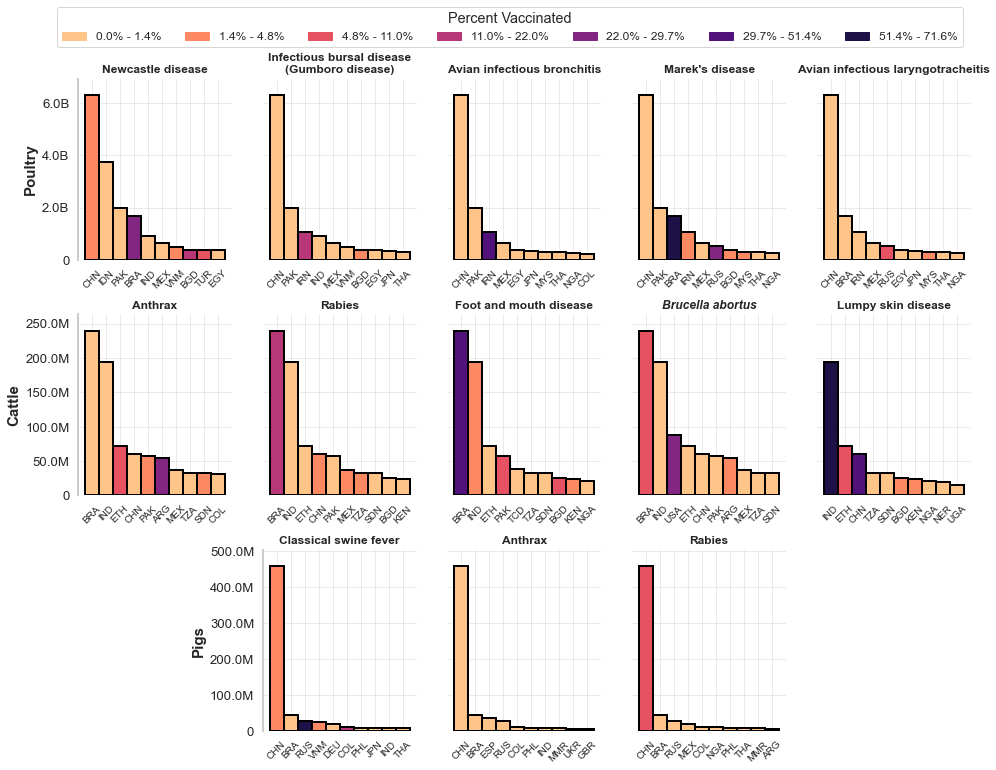

In [19]:
x_tick_distance = 1.5   # Spacing between x-ticks.
bar_width = 1.5         # Bar width.
classes = 7             # Use 7 classes for clarity.

def easier_format(num, pos):
    """Format large numbers in a more readable format."""
    if num >= 1_000_000_000:
        return f'{num / 1_000_000_000:.1f}B'
    elif num >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'
    elif num >= 1_000:
        return f'{num / 1_000:.1f}K'
    return str(int(num))
df_2024 = df_calculations_vacc[df_calculations_vacc["Year"] == 2024].copy()
df_2024["Unvaccinated"] = (df_2024["latest pop"] - df_2024["Number of Vaccinated Estimate"]).clip(lower=0)

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams.update({
    'axes.linewidth': 2,
    'grid.alpha': 0.4,
    'xtick.major.size': 5,
    'ytick.major.size': 5
})

animal_groups = {"Poultry": [], "Cattle": [], "Pigs": []}
for disease in diseases_info:
    if disease["Animal"] in animal_groups:
        animal_groups[disease["Animal"]].append(disease)

cols = 5   
rows = len(animal_groups)  

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), sharey=False)
fig.subplots_adjust(hspace=0.3)

if rows == 1:
    axes = [axes]
else:
    axes = axes.reshape(rows, cols)

subplot_info = []   
global_percents = []
max_y_values = {}   

for row_idx, (animal, diseases) in enumerate(animal_groups.items()):
    max_y_values[animal] = 0  
    for col_idx, disease_info in enumerate(diseases):
        disease_name = disease_info["Disease"]
        
        if animal != 'Pigs':
            ax = axes[row_idx, col_idx]
            if col_idx == 0:
                ax.set_ylabel(animal, fontsize=15, fontweight='bold')
                ax.spines['left'].set_visible(True)
                ax.spines['left'].set_linewidth(2)
                ax.tick_params(axis='y', labelleft=True)
            else:
                ax.set_ylabel("")
                ax.spines['left'].set_visible(False)
                ax.tick_params(axis='y', labelleft=False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
        else:
            col_idx_shifted = col_idx + 1  # shift right by one column.
            ax = axes[row_idx, col_idx_shifted]
            if col_idx_shifted == 1:
                ax.set_ylabel(animal, fontsize=15, fontweight='bold')
                ax.spines['left'].set_visible(True)
                ax.spines['left'].set_linewidth(2)
                ax.tick_params(axis='y', labelleft=True)
            else:
                ax.set_ylabel("")
                ax.spines['left'].set_visible(False)
                ax.tick_params(axis='y', labelleft=False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
        if 'castle' not in disease_name:
            df_disease = df_2024[
                (df_2024["Disease"] == disease_name) & (df_2024["Animal"] == animal) &(df_2024['Estimated (Scaled) Cases'].notna())
                                                                                        &(df_2024['Source_x']!='Imputed')
            ]
        else:
            df_disease = df_2024[
                (df_2024["Disease"] == disease_name) & (df_2024["Animal"] == animal) &(df_2024['Source_x']!='Imputed')
            ]         
        if df_disease.empty:
            ax.set_visible(False)
            continue

        df_disease = df_disease.copy()  # to add new columns
        df_disease["Total"] = df_disease["Number of Vaccinated Estimate"] + df_disease["Unvaccinated"]
        df_disease["Percent_Vaccinated"] = df_disease.apply(
            lambda row: (row["Number of Vaccinated Estimate"] / row["Total"] * 100) if row["Total"] > 0 else 0,
            axis=1
        )
        
        top_countries = df_disease.nlargest(10, "Unvaccinated").copy()
        if top_countries.empty:
            ax.set_visible(False)
            continue
        top_countries = top_countries.sort_values("latest pop", ascending=False).reset_index(drop=True)

        current_max = top_countries["Total"].max()
        max_y_values[animal] = max(max_y_values.get(animal, 0), current_max)
        
        x_positions = np.arange(len(top_countries)) * x_tick_distance
        
        # Accumulate percent vaccinated values.
        global_percents.extend(top_countries["Percent_Vaccinated"].tolist())
        
        if 'bursal' in disease_name.lower():
            plot_title = 'Infectious bursal disease\n(Gumboro disease)'
        else:
            plot_title = disease_name.replace(' (Inf. with)', '').replace(' (-2011)', '').replace(' virus','')

        if disease_name == "Brucella abortus (Inf. with)":
            ax.set_title("Brucella abortus", fontsize=12, fontweight="bold", fontstyle="italic")
        else:
            ax.set_title(plot_title, fontsize=12, fontweight='bold')

        ax.set_xticks(x_positions)
        ax.set_xticklabels(top_countries["ISO3"], rotation=45, fontsize=10)
        if row_idx < rows - 1:
            ax.set_xlabel("")
        
        subplot_info.append({
            "ax": ax,
            "top_countries": top_countries,
            "x_positions": x_positions,
            "animal": animal
        })

global_breaks = jenkspy.jenks_breaks(global_percents, n_classes=classes)

def get_group(value, breaks):
    """Return the group index that 'value' falls into given 'breaks'."""
    for i in range(len(breaks) - 1):
        if breaks[i] <= value <= breaks[i+1]:
            return i
    return len(breaks) - 2

colors = sns.color_palette("magma", classes)[::-1]

for info in subplot_info:
    ax = info["ax"]
    top_countries = info["top_countries"]
    x_positions = info["x_positions"]
    
    bar_colors = []
    for idx, row in top_countries.iterrows():
        pct = row["Percent_Vaccinated"]
        group = get_group(pct, global_breaks)
        bar_colors.append(colors[group])
    
    ax.bar(
        x_positions,
        top_countries["Total"],
        width=bar_width,
        color=bar_colors,
        edgecolor="black",
        linewidth=2
    )
    
    ax.ticklabel_format(style='plain', useOffset=False, axis='y')
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(easier_format))
    ax.set_yscale("linear")
    ticks = ax.get_yticks()
    ax.set_yticklabels([easier_format(tick, None) for tick in ticks])

for info in subplot_info:
    animal = info["animal"]
    ax = info["ax"]
    ax.set_ylim(0, max_y_values[animal] * 1.1)

legend_handles = []
for i in range(classes):
    label = f"{global_breaks[i]:.1f}% - {global_breaks[i+1]:.1f}%"
    patch = mpatches.Patch(color=colors[i], label=label)
    legend_handles.append(patch)
    
for row_idx in range(rows):
    if row_idx == 2:  
        axes[2, 0].set_visible(False)
        axes[2, 4].set_visible(False)
    
fig.legend(handles=legend_handles, title="Percent Vaccinated", ncol=classes,
           loc="upper center", bbox_to_anchor=(0.5, 0.97), fontsize=12)
fig.savefig("vaccination_potential_color_gradient.svg", format="svg", dpi=600, bbox_inches="tight")
fig.savefig("vaccination_potential_color_gradient.png", format="png", dpi=600, bbox_inches="tight")

plt.show()


<ipython-input-20-612ee936114a>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disease["Unvaccinated"] = df_disease["latest pop"] - df_disease["Number of Vaccinated Estimate"]


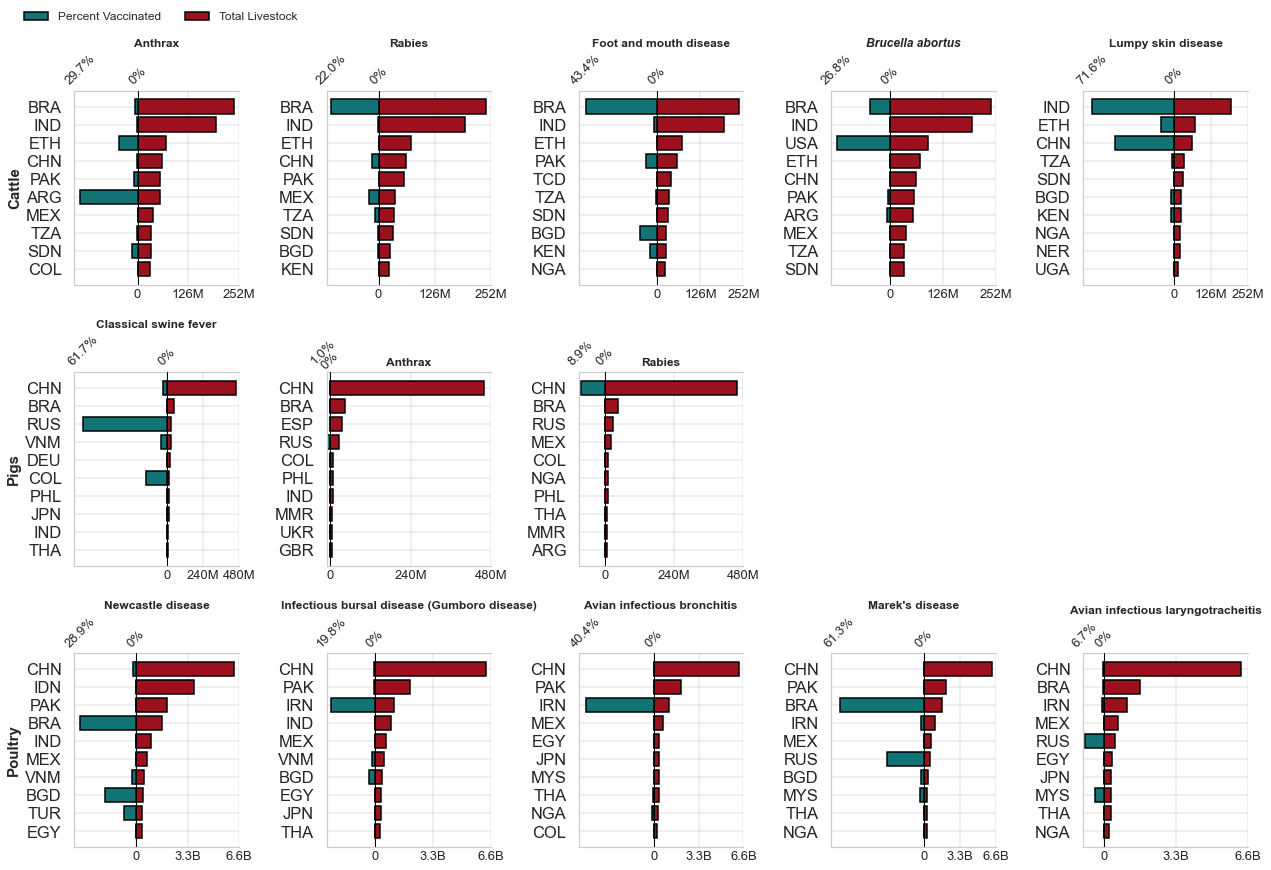

In [20]:
show_me = []
showme_2 = []

to_export_dfs=[]

total_color='#9B111E' # Imperial red
vacc_color = "#127475" # Deep cyan

def easier_format(num, pos):
    """
    Format large numbers into a more readable format.
    """
    if num >= 1_000_000_000:
        return f"{num/1_000_000_000:.1f}B"
    elif num >= 1_000_000:
        return f"{round(num/1_000_000)}M"
    elif num >= 1_000:
        return f"{round(num/1_000)}K"
    elif num >= 100:
        return f"{int(round(num, -2))}"
    else:
        return str(int(num))

def diverging_formatter_factory(s):
    def formatter(x, pos):
        if x < 0:
            return f"{abs(x)/s:.0f}%"
        else:
            return easier_format(x, pos)
    return formatter

df_2024 = df_calculations_vacc[df_calculations_vacc["Year"] == 2024].copy()

animal_groups = {"Cattle": [], "Pigs": [], "Poultry": []}
for disease in diseases_info:
    animal = disease["Animal"]
    if animal in animal_groups:
        animal_groups[animal].append(disease)
    else:
        animal_groups[animal] = [disease]

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)
plt.rcParams["axes.linewidth"] = 1.2

cols = 5  
rows = len(animal_groups)
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4), sharex=False, sharey=False)
if rows == 1:
    axes = [axes]
else:
    axes = axes.reshape(rows, cols)
    
for row_idx, (animal, diseases) in enumerate(animal_groups.items()):
    group_max_total = df_2024[df_2024["Animal"] == animal]["latest pop"].max()
    group_common_xlim_right = group_max_total * 1.05
    group_xticks = np.linspace(0, group_common_xlim_right, 3)
    group_xtick_labels = [easier_format(x, None) for x in group_xticks]

    if not diseases:
        for c in range(cols):
            axes[row_idx, c].set_visible(False)
        continue

    for col_idx in range(cols):
        if col_idx < len(diseases):
            disease_info = diseases[col_idx]
            disease_name = disease_info["Disease"]
            ax = axes[row_idx, col_idx]

            if 'castle' not in disease_name:
                df_disease = df_2024[
                    (df_2024["Disease"] == disease_name) & 
                    (df_2024["Animal"] == animal) & 
                    (df_2024['Estimated (Scaled) Cases'].notna()) &
                    (df_2024['Source_x'] != 'Imputed')
                ]
            else:
                df_disease = df_2024[
                    (df_2024["Disease"] == disease_name) & 
                    (df_2024["Animal"] == animal) & 
                    (df_2024['Source_x'] != 'Imputed')
                ]
                
            df_disease["Unvaccinated"] = df_disease["latest pop"] - df_disease["Number of Vaccinated Estimate"]

            top_countries = df_disease.nlargest(10, "Unvaccinated").copy()
            if top_countries.empty:
                ax.set_visible(False)
                continue

            max_total = top_countries['latest pop'].max()
            scale_factor = 10 * (max_total * 0.2 / 100)
            common_xlim_right = group_common_xlim_right  
            show_me += [top_countries]

            top_countries["vacc_percent"] = (
                top_countries["Number of Vaccinated Estimate"] / top_countries["latest pop"] * 100
            )
            to_export_dfs.append(top_countries)
            top_countries.sort_values("latest pop", ascending=False, inplace=True)

            local_max = top_countries["vacc_percent"].max()
            showme_2 += [local_max]

            # Label the leftmost subplot in each row with the animal name.
            if col_idx == 0:
                ax.set_ylabel(animal, fontsize=15, fontweight='bold')
            else:
                ax.set_ylabel("")
            display_max = local_max

            local_xlim_left = - (local_max * scale_factor * 1.05)

            ax.set_xlim(local_xlim_left * 1.05, common_xlim_right)

            ax.set_xticks(group_xticks)
            ax.set_xticklabels(group_xtick_labels, fontsize=13)  # increased font size for tick labels
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(diverging_formatter_factory(scale_factor)))
            ax.tick_params(axis='x', which='major', length=0, width=0, direction='in', rotation=0, labelsize=13)

            # SECONDARY X-AXIS (top): Vaccinated (%).
            # These ticks reflect the blue bars (vaccinated %) on the negative side.
            secax = ax.secondary_xaxis('top')
            secax.set_xlim(-1 * (-local_xlim_left) * 1.05, 0)
            
            if local_max > 1.1:
                secax.set_xticks([-1 * (local_max * scale_factor), 0])            
                secax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
                secax.set_xticklabels([f"{local_max:.1f}%", f"{0}%"], fontsize=13)
            else:
                tick_pos = -1 * (local_max * scale_factor)
                secax.set_xticks([tick_pos, 0])
                secax.set_xticklabels(["", ""])
                ax.text(tick_pos * 2.5, 1.025, f"{local_max:.1f}%", 
                        ha='center', va='bottom', fontsize=13, rotation=45,
                        transform=ax.get_xaxis_transform())
                ax.text(0, 1.0, f"{0}%", 
                        ha='center', va='bottom', fontsize=13, rotation=45,
                        transform=ax.get_xaxis_transform())

            secax.tick_params(axis='x', rotation=45, length=0, width=0, labelsize=13)

            ax.axvline(0, color="black", linewidth=1)
            ax.invert_yaxis()
            
            if disease_name == "Brucella abortus (Inf. with)":
                ax.set_title("Brucella abortus", fontsize=12, fontweight="bold", fontstyle="italic")
            else:
                title_text = disease_name.replace(' (Inf. with)', '').replace(' (-2011)', '').replace(' virus','')
                if title_text.strip().lower() == "rabies" and animal.lower() == "pigs":
                    ax.set_title(title_text, fontsize=12, fontweight='bold',y=1)
                else:
                    ax.set_title(title_text, fontsize=12, fontweight='bold')
                

            ax.barh(top_countries["ISO3"], top_countries["latest pop"],
                    color=total_color, edgecolor="black", label="Total Livestock")
            ax.barh(top_countries["ISO3"], - top_countries["vacc_percent"] * scale_factor,
                    color=vacc_color, edgecolor="black", label="Percent Vaccinated")
        else:
            axes[row_idx, col_idx].set_visible(False)

handles, labels = [], []
for row in axes:
    for ax in row:
        if ax.get_visible():
            handles, labels = ax.get_legend_handles_labels()
            if handles and labels:
                break
    if handles and labels:
        break

handles, labels = handles[::-1], labels[::-1]

fig.legend(handles, labels, ncol=2, loc="upper left", bbox_to_anchor=(0.02, 1.02),
           frameon=False, fontsize=12)

sns.despine(fig=fig, left=False, bottom=False)
plt.tight_layout()

fig.savefig("vaccination_potential_back_to_back_bars.svg", format="svg", dpi=600, bbox_inches="tight")
fig.savefig("vaccination_potential_back_to_back_bars.png", format="png", dpi=600, bbox_inches="tight")
plt.show()


In [21]:
poultry_most_countries=[]
cattle_most_countries=[]
pigs_most_countries=[]

def add_scientific_notation(paragraph, value, precision=2):
    """
    Format a numeric value into scientific notation (e.g., 1.30 x 10^3)
    and add it to the given paragraph with the exponent as superscript.
    """
    if pd.isnull(value):
        paragraph.add_run("")
        return
    formatted = f"{value:.{precision}e}"
    base, exponent = formatted.split('e')
    exponent_int = int(exponent)  
    run1 = paragraph.add_run(f"{base} x 10")
    run1.font.size = Pt(8.5)
    run2 = paragraph.add_run(str(exponent_int))
    run2.font.superscript = True
    run2.font.size = Pt(8.5)

doc = Document()

for df in to_export_dfs:
    df = df[df['Year'] == 2024]
    animal = df['Animal'].values[0]
    disease_name = df['Disease'].values[0]
    
    df['Number of Unvaccinated Estimate']=df['latest pop']-df['Number of Vaccinated Estimate']
    
    prelim = df.loc[:, ['Country','Vaccination Coverage (%)',
                          'Year Data_x','latest pop','Number of Unvaccinated Estimate',
                          'Aggregate of Latest Reported Cases (up to Year)','Estimated (Scaled) Cases',
                          'Year Data_y']]
    
    prelim.rename(columns={'latest pop': 'Population',
                           'Vaccination Coverage (%)': 'Vaccination Coverage Estimate (%)',
                           'Year Data_x': 'Year Coverage Data',
                           'Number of Unvaccinated Estimate': 'Number of Unvaccinated',
                           'Year Data_y': 'Year Cases Data'}, inplace=True)
    
    prelim['Number of Unvaccinated'] = prelim['Number of Unvaccinated'].round(0).astype('Int64')
    prelim['Population'] = prelim['Population'].round(0).astype('Int64')
    prelim['Estimated (Scaled) Cases'] = prelim['Estimated (Scaled) Cases'].round(0).astype('Int64')
    prelim['Aggregate of Latest Reported Cases (up to Year)'] = prelim['Aggregate of Latest Reported Cases (up to Year)'].round(0).astype('Int64')
    prelim['Vaccination Coverage Estimate (%)'] = prelim['Vaccination Coverage Estimate (%)'].round(2)
    
    if animal.lower()=='poultry':
        poultry_most_countries+=prelim['Country'].values.tolist()
    elif animal.lower()=='cattle':
        cattle_most_countries+=prelim['Country'].values.tolist()
    elif animal.lower()=='pigs':
        pigs_most_countries+=prelim['Country'].values.tolist()
    if 'virus' in disease_name:
        disease_name = disease_name.replace(' virus', '')
    if '(Inf. with)' in disease_name:
        disease_name = disease_name.replace(' (Inf. with)', '')
    disease_name = re.sub(" [\(\[]-[\d]{4}[\)\]]", "", disease_name)
    disease_name = disease_name.title()
    
    if disease_name == 'Haemorrhagic Septicaemia (Pasteurella Multocida Serotypes 6:B And 6:E)':
        disease_name = 'Haemorrhagic Septicaemia'
    if disease_name == "Marek'S Disease":
        disease_name = "Marek's Disease"
        
    prelim = prelim.reset_index(drop=True)        
    
    df_top = prelim.sort_values(by=['Number of Unvaccinated'], ascending=False)

    special_cols = ['Population', 'Number of Unvaccinated']
    
    for df_temp, case_type in zip([df_top], ["top reported cases"]):
        sentence = f"The top ten countries at risk of {disease_name} outbreak in {animal} based on disease presence and unvaccinated animals in 2024."
        paragraph = doc.add_paragraph(sentence)
        paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
        
        table = doc.add_table(rows=1, cols=len(df_temp.columns))
        table.style = 'Table Grid'
        
        hdr_cells = table.rows[0].cells
        for i, column in enumerate(df_temp.columns):
            hdr_cells[i].text = column
            hdr_cells[i].paragraphs[0].runs[0].font.bold = True
            run = hdr_cells[i].paragraphs[0].runs[0]  # Get the first run
            run.font.bold = True
            run.font.size = Pt(9.5)  # Set font size to 10 pt
        
        for _, row in df_temp.iterrows():
            row_cells = table.add_row().cells
            for i, col in enumerate(df_temp.columns):
                row_cells[i].text = ""
                cell_paragraph = row_cells[i].paragraphs[0]
                if col in special_cols:
                    add_scientific_notation(cell_paragraph, row[col], precision=2)
                else:
                    run = cell_paragraph.add_run(str(row[col]))
                    run.font.size = Pt(8.5)
        
        doc.add_paragraph("\n")
    
    doc.add_page_break()

doc.save("top_at_risk_countries_by_disease.docx")

In [22]:
Counter(pigs_most_countries).most_common()

[('China', 3),
 ('Brazil', 3),
 ('Russian Federation', 3),
 ('Colombia', 3),
 ('Philippines', 3),
 ('India', 2),
 ('Thailand', 2),
 ('Myanmar', 2),
 ('Viet Nam', 1),
 ('Germany', 1),
 ('Japan', 1),
 ('Spain', 1),
 ('Ukraine', 1),
 ('United Kingdom', 1),
 ('Mexico', 1),
 ('Nigeria', 1),
 ('Argentina', 1)]

In [23]:
Counter(cattle_most_countries).most_common()

[('India', 5),
 ('Ethiopia', 5),
 ('Tanzania, United Republic of', 5),
 ('Sudan', 5),
 ('Brazil', 4),
 ('China', 4),
 ('Pakistan', 4),
 ('Mexico', 3),
 ('Bangladesh', 3),
 ('Kenya', 3),
 ('Argentina', 2),
 ('Nigeria', 2),
 ('Colombia', 1),
 ('Chad', 1),
 ('United States', 1),
 ('Niger', 1),
 ('Uganda', 1)]

In [24]:
Counter(poultry_most_countries).most_common()

[('China', 5),
 ('Mexico', 5),
 ('Pakistan', 4),
 ('Egypt', 4),
 ('Iran, Islamic Republic of', 4),
 ('Thailand', 4),
 ('Brazil', 3),
 ('Bangladesh', 3),
 ('Japan', 3),
 ('Malaysia', 3),
 ('Nigeria', 3),
 ('India', 2),
 ('Viet Nam', 2),
 ('Russian Federation', 2),
 ('Indonesia', 1),
 ('Türkiye, Republic of', 1),
 ('Colombia', 1)]

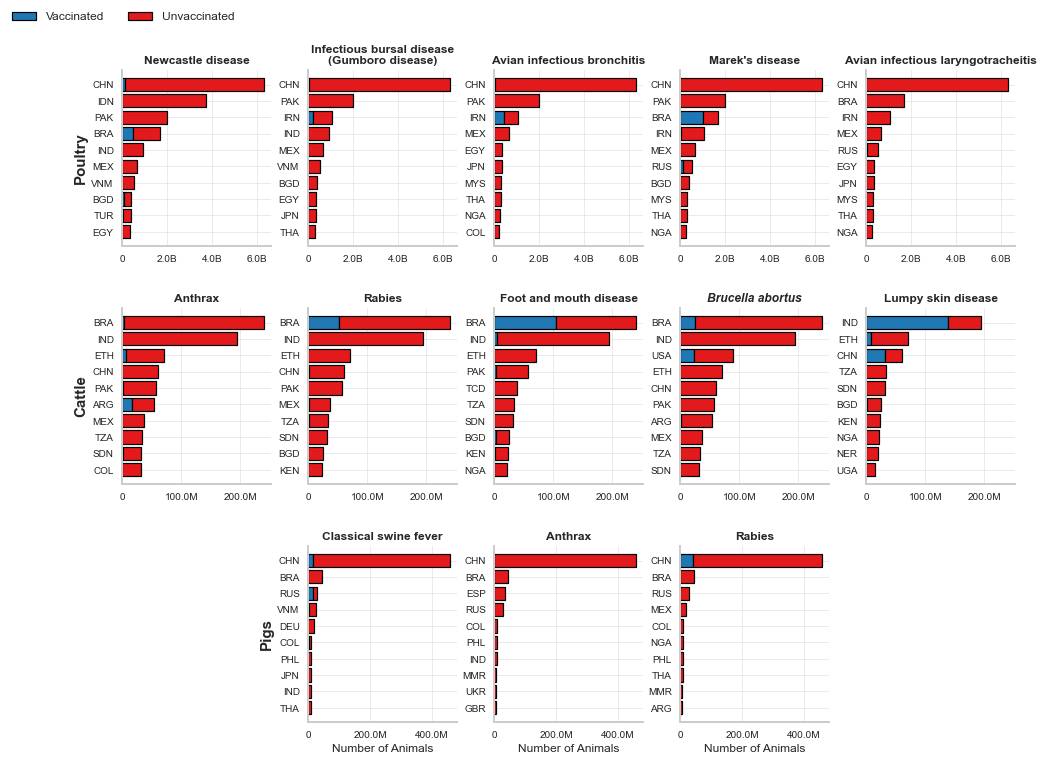

In [25]:
plt.rcParams["font.family"] = "Arial"

# Function to format large numbers into more readable format
def easier_format(num, pos):
    if num >= 1_000_000_000:
        return f'{num / 1_000_000_000:.1f}B'  # Billions
    elif num >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'  # Millions
    elif num >= 1_000:
        return f'{num / 1_000:.1f}K'  # Thousands
    return str(int(num)) 

df_2024 = df_calculations_vacc[df_calculations_vacc["Year"] == 2024].copy()

# Calculate unvaccinated animals
df_2024["Unvaccinated"] = df_2024["latest pop"] - df_2024["Number of Vaccinated Estimate"]
df_2024["Unvaccinated"] = df_2024["Unvaccinated"].clip(lower=0)

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams.update({
    'axes.linewidth': 2, 
    'grid.alpha': 0.4, 
    'xtick.major.size': 5, 
    'ytick.major.size': 5
})

animal_groups = {"Poultry": [], "Cattle": [], "Pigs": []}
for disease in diseases_info:
    animal_groups[disease["Animal"]].append(disease)

cols = 5 
rows = len(animal_groups) 

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.35, wspace=0.25)

if rows == 1:
    axes = [axes]
else:
    axes = axes.reshape(rows, cols)

max_total_values = {}

for row_idx, (animal, diseases) in enumerate(animal_groups.items()):
    group_max = 0  
    
    for col_idx, disease_info in enumerate(diseases):
        if animal == "Pigs":
            plot_col = col_idx + 1
        else:
            plot_col = col_idx

        ax = axes[row_idx, plot_col]

        if (animal != "Pigs" and plot_col == 0) or (animal == "Pigs" and plot_col == 1):
            ax.set_ylabel(animal, fontsize=15, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        disease_name = disease_info["Disease"]
        if 'castle' not in disease_name:
            df_disease = df_2024[
                (df_2024["Disease"] == disease_name) & (df_2024["Animal"] == animal) &(df_2024['Estimated (Scaled) Cases'].notna())
                                                                                      &(df_2024['Source_x']!='Imputed')
            ]
        else:
            df_disease = df_2024[
                (df_2024["Disease"] == disease_name) & (df_2024["Animal"] == animal) &(df_2024['Source_x']!='Imputed')
            ]         

        top_countries = df_disease.nlargest(10, "Unvaccinated").copy()
        if top_countries.empty:
            ax.set_visible(False)  
            continue

        # Sort by total population (latest pop) for clarity
        top_countries = top_countries.sort_values("latest pop", ascending=False)
        
        if 'bursal' in disease_name.lower():
            disease_name = 'Infectious bursal disease\n(Gumboro disease)'

        countries = top_countries["ISO3"]
        vaccinated = top_countries["Number of Vaccinated Estimate"]
        unvaccinated = top_countries["Unvaccinated"]

        ax.barh(countries, vaccinated, 
                label="Vaccinated", color="#1f78b4", edgecolor="black", linewidth=1.2)
        ax.barh(countries, unvaccinated, 
                left=vaccinated, label="Unvaccinated", color="#e31a1c", edgecolor="black", linewidth=1.2)

        ax.invert_yaxis()

        if disease_name == "Brucella abortus (Inf. with)":
            ax.set_title("Brucella abortus", fontsize=12, fontweight="bold", fontstyle="italic")
        else:
            ax.set_title(disease_name.replace(' (Inf. with)', '').replace(' (-2011)', '').replace(' virus',''),
                     fontsize=12, fontweight='bold')


        total = (vaccinated + unvaccinated).max()
        group_max = max(group_max, total)

        if row_idx == rows - 1:
            ax.set_xlabel("Number of Animals", fontsize=12)
        else:
            ax.set_xlabel("")

        ax.tick_params(axis='both', labelsize=10)

    max_total_values[animal] = group_max

for row_idx, (animal, _) in enumerate(animal_groups.items()):
    for col_idx in range(cols):
        ax = axes[row_idx, col_idx]
        if ax.get_visible():
            ax.set_xlim(0, max_total_values[animal] * 1.05)  # add a 5% margin
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(easier_format))

for row_idx in range(rows):
    if row_idx == 2:  # Assuming row 2 is for Pigs
        axes[2, 0].set_visible(False)
        axes[2, 4].set_visible(False)

handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="upper left", bbox_to_anchor=(0.02, 0.96), 
           frameon=False, fontsize=12)

fig.savefig("vaccination_potential_stacked_original_horizontal.svg", format="svg", dpi=600, bbox_inches="tight")
fig.savefig("vaccination_potential_stacked_original_horizontal.png", format="png", dpi=600, bbox_inches="tight")


plt.show()


### Calculate potential vaccination coverage increase in all at-risk populations of animals

<ipython-input-26-b295d892b470>:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_countries["ISO3"], rotation=45, fontsize=10)


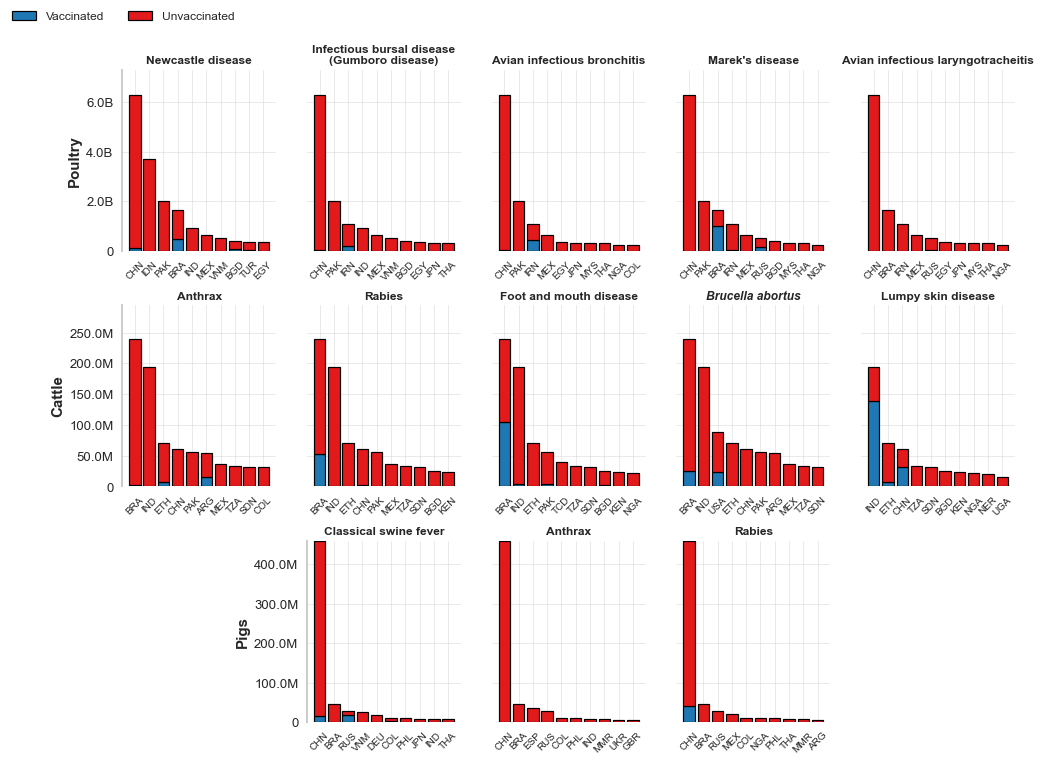

In [26]:
# Function to format large numbers into more readable format
def easier_format(num, pos):
    if num >= 1_000_000_000:
        return f'{num / 1_000_000_000:.1f}B'  # Billions
    elif num >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'  # Millions
    elif num >= 1_000:
        return f'{num / 1_000:.1f}K'  # Thousands
    return str(int(num))  # For smaller numbers

df_2024 = df_calculations_vacc[df_calculations_vacc["Year"] == 2024].copy()

# Calculate unvaccinated animals
df_2024["Unvaccinated"] = df_2024["latest pop"] - df_2024["Number of Vaccinated Estimate"]
df_2024["Unvaccinated"] = df_2024["Unvaccinated"].clip(lower=0)  

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["font.family"] = "Arial"

plt.rcParams.update({'axes.linewidth': 2, 
                     'grid.alpha': 0.4, 
                     'xtick.major.size': 5, 
                     'ytick.major.size': 5})

animal_groups = {"Poultry": [], "Cattle": [], "Pigs": []}
for disease in diseases_info:
    animal_groups[disease["Animal"]].append(disease)

cols = 5  
rows = len(animal_groups)  

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), sharey=False)
fig.subplots_adjust(hspace=0.3)  

if rows == 1:
    axes = [axes]
else:
    axes = axes.reshape(rows, cols)

max_y_values = {}

for row_idx, (animal, diseases) in enumerate(animal_groups.items()):
    max_y = 0  
    
    for col_idx, disease_info in enumerate(diseases):
        disease_name = disease_info["Disease"]
        
        if animal != 'Pigs':
            ax = axes[row_idx, col_idx]
            if col_idx == 0:
                ax.set_ylabel(animal, fontsize=15, fontweight='bold')
                ax.spines['left'].set_visible(True)
                ax.spines['left'].set_linewidth(2)
                ax.tick_params(axis='y', labelleft=True)  # Enable y-tick labels
            else:
                ax.set_ylabel("")
                ax.spines['left'].set_visible(False)
                ax.tick_params(axis='y', labelleft=False)  # Hide tick labels
                
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
        else:
            # For Pigs, we want the leftmost visible axis to be in the second column.
            # (We “skip” the first subplot by shifting the index.)
            col_idx += 1 
            ax = axes[row_idx, col_idx]
            if col_idx == 1:
                ax.set_ylabel(animal, fontsize=15, fontweight='bold')
                ax.spines['left'].set_visible(True)
                ax.spines['left'].set_linewidth(2)
                ax.tick_params(axis='y', labelleft=True)  # Enable y-tick labels on the designated subplot
            else:
                ax.set_ylabel("")
                ax.spines['left'].set_visible(False)
                ax.tick_params(axis='y', labelleft=False)
                
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
        
        if 'castle' not in disease_name:
            df_disease = df_2024[
                (df_2024["Disease"] == disease_name) & (df_2024["Animal"] == animal) &(df_2024['Estimated (Scaled) Cases'].notna())
                                                                                      &(df_2024['Source_x']!='Imputed')
            ]
        else:
            df_disease = df_2024[
                (df_2024["Disease"] == disease_name) & (df_2024["Animal"] == animal) &(df_2024['Source_x']!='Imputed')
            ]         


        top_countries = df_disease.nlargest(10, "Unvaccinated").copy()
        if top_countries.empty:
            ax.set_visible(False)  # Hide unused plots
            continue

        top_countries = top_countries.sort_values("latest pop", ascending=False)
        if 'bursal' in disease_name.lower():
            disease_name = 'Infectious bursal disease\n(Gumboro disease)'

        ax.bar(
            top_countries["ISO3"], top_countries["Number of Vaccinated Estimate"],
            label="Vaccinated", color="#1f78b4", edgecolor="black", linewidth=1.2
        )
        ax.bar(
            top_countries["ISO3"], top_countries["Unvaccinated"],
            bottom=top_countries["Number of Vaccinated Estimate"],
            label="Unvaccinated", color="#e31a1c", edgecolor="black", linewidth=1.2
        )

        if disease_name == "Brucella abortus (Inf. with)":
            ax.set_title("Brucella abortus", fontsize=12, fontweight="bold", fontstyle="italic")
        else:
            ax.set_title(disease_name.replace(' (Inf. with)', '').replace(' (-2011)', '').replace(' virus',''),
                     fontsize=12, fontweight='bold')

        max_y = max(max_y, 
                    top_countries["Number of Vaccinated Estimate"].max() + 
                    top_countries["Unvaccinated"].max())

        ax.set_xticklabels(top_countries["ISO3"], rotation=45, fontsize=10)

        if row_idx < rows - 1:
            ax.set_xlabel("")


    max_y_values[animal] = max_y

for row_idx, (animal, _) in enumerate(animal_groups.items()):
    for col_idx in range(cols):
        ax = axes[row_idx, col_idx]
        if ax.get_visible():
            ax.set_ylim(0, max_y_values[animal])
            ax.yaxis.set_major_formatter(mtick.FuncFormatter(easier_format))

for row_idx in range(rows):
    if row_idx == 2:
        axes[2, 0].set_visible(False)
        axes[2, 4].set_visible(False)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="upper left", bbox_to_anchor=(0.02, .96), 
           frameon=False, fontsize=12)
fig.savefig("vaccination_potential_stacked_original_vertical.svg", format="svg", dpi=600, bbox_inches="tight")
fig.savefig("vaccination_potential_stacked_original_vertical.png", format="png", dpi=600, bbox_inches="tight")

plt.show()


In [27]:
animal_groups

simplified_animal_diseases=dict()

for animal in animal_groups.keys():
    simplified_animal_diseases[animal]=[i['Disease'] for i in animal_groups[animal]]

In [28]:
simplified_animal_diseases={
 'Cattle': ['Anthrax',
  'Rabies virus (Inf. with)',
  'Foot and mouth disease virus (Inf. with)',
  'Brucella abortus (Inf. with)',
  'Lumpy skin disease virus (Inf. with)'],
 'Pigs': ['Classical swine fever virus (Inf. with)',
  'Anthrax',
  'Rabies virus (Inf. with)'],
 'Poultry': ['Newcastle disease',
  'Infectious bursal disease (Gumboro disease)',
  'Avian infectious bronchitis',
  "Marek's disease (-2011)",
  'Avian infectious laryngotracheitis'],}


In [29]:

print('Gap in vaccination (Extent of under-vaccination, i.e., how much below 100%):')
df_2024 = df_calculations_vacc[df_calculations_vacc["Year"] == 2024].copy()

df_2024["Unvaccinated"] = df_2024["latest pop"] - df_2024["Number of Vaccinated Estimate"]
df_2024["Unvaccinated"] = df_2024["Unvaccinated"].clip(lower=0)  # Prevent negative values

animal_groups = {"Poultry": [], "Cattle": [], "Pigs": []}
for disease in diseases_info:
    animal_groups[disease["Animal"]].append(disease)
    


for row_idx, (animal, diseases) in enumerate(simplified_animal_diseases.items()):
    for disease in diseases:
        print(animal,':',disease,'true, lower, upper')

        if 'castle' not in disease:
            df_disease = df_2024[
                (df_2024["Disease"] == disease) &
                (df_2024["Animal"] == animal)&
                (df_2024['Number of Vaccinated Estimate'].notna())&
                ((df_2024['Estimated (Scaled) Cases'].notna())|(df_2024['Aggregate of Latest Reported Cases (up to Year)'].notna()))
            ]
        else:
            df_disease = df_2024[
                (df_2024["Disease"] == disease) &
                (df_2024["Animal"] == animal)&
                (df_2024['Number of Vaccinated Estimate'].notna())
            ]

        df_disease
        coverage_lower=sum(df_disease['Number of Vaccinated Lower'].values)/sum(df_disease['latest pop'].values)
        coverage_upper=sum(df_disease['Number of Vaccinated Upper'].values)/sum(df_disease['latest pop'].values)
        coverage=sum(df_disease['Number of Vaccinated Estimate'].values)/sum(df_disease['latest pop'].values)

        print(round(1-coverage,4))
        print('('+str(round(1-coverage_upper,4))+',',str((round(1-coverage_lower,4)))+')')        


Gap in vaccination (Extent of under-vaccination, i.e., how much below 100%):
Cattle : Anthrax true, lower, upper
0.8966
(0.874, 0.9093)
Cattle : Rabies virus (Inf. with) true, lower, upper
0.8489
(0.7874, 0.8785)
Cattle : Foot and mouth disease virus (Inf. with) true, lower, upper
0.6989
(0.6988, 0.699)
Cattle : Brucella abortus (Inf. with) true, lower, upper
0.9545
(0.9408, 0.9622)
Cattle : Lumpy skin disease virus (Inf. with) true, lower, upper
0.6716
(0.6646, 0.6763)
Pigs : Classical swine fever virus (Inf. with) true, lower, upper
0.9129
(0.9045, 0.9172)
Pigs : Anthrax true, lower, upper
0.945
(0.8808, 0.9701)
Pigs : Rabies virus (Inf. with) true, lower, upper
0.9269
(0.8076, 0.9626)
Poultry : Newcastle disease true, lower, upper
0.8201
(0.8156, 0.8229)
Poultry : Infectious bursal disease (Gumboro disease) true, lower, upper
0.838
(0.7936, 0.849)
Poultry : Avian infectious bronchitis true, lower, upper
0.8293
(0.799, 0.8383)
Poultry : Marek's disease (-2011) true, lower, upper
0.92

In [30]:
print('Vaccination Coverage in the Global At-Risk Populations:')
df_2024 = df_calculations_vacc[df_calculations_vacc["Year"] == 2024].copy()

df_2024["Unvaccinated"] = df_2024["latest pop"] - df_2024["Number of Vaccinated Estimate"]
df_2024["Unvaccinated"] = df_2024["Unvaccinated"].clip(lower=0)  # Prevent negative values

animal_groups = {"Poultry": [], "Cattle": [], "Pigs": []}
for disease in diseases_info:
    animal_groups[disease["Animal"]].append(disease)
    


for row_idx, (animal, diseases) in enumerate(simplified_animal_diseases.items()):
    for disease in diseases:
        print(animal,':',disease,'true, lower, upper')

        if 'castle' not in disease:
            df_disease = df_2024[
                (df_2024["Disease"] == disease) &
                (df_2024["Animal"] == animal)&
                (df_2024['Number of Vaccinated Estimate'].notna())&
                ((df_2024['Estimated (Scaled) Cases'].notna())|(df_2024['Aggregate of Latest Reported Cases (up to Year)'].notna()))
            ]
        else:
            df_disease = df_2024[
                (df_2024["Disease"] == disease) &
                (df_2024["Animal"] == animal)&
                (df_2024['Number of Vaccinated Estimate'].notna())
            ]

        df_disease
        coverage_lower=sum(df_disease['Number of Vaccinated Lower'].values)/sum(df_disease['latest pop'].values)
        coverage_upper=sum(df_disease['Number of Vaccinated Upper'].values)/sum(df_disease['latest pop'].values)
        coverage=sum(df_disease['Number of Vaccinated Estimate'].values)/sum(df_disease['latest pop'].values)

        print(round(coverage,4))
        print('('+str(round(coverage_lower,4))+',',str((round(coverage_upper,4)))+')')        


Vaccination Coverage in the Global At-Risk Populations:
Cattle : Anthrax true, lower, upper
0.1034
(0.0907, 0.126)
Cattle : Rabies virus (Inf. with) true, lower, upper
0.1511
(0.1215, 0.2126)
Cattle : Foot and mouth disease virus (Inf. with) true, lower, upper
0.3011
(0.301, 0.3012)
Cattle : Brucella abortus (Inf. with) true, lower, upper
0.0455
(0.0378, 0.0592)
Cattle : Lumpy skin disease virus (Inf. with) true, lower, upper
0.3284
(0.3237, 0.3354)
Pigs : Classical swine fever virus (Inf. with) true, lower, upper
0.0871
(0.0828, 0.0955)
Pigs : Anthrax true, lower, upper
0.055
(0.0299, 0.1192)
Pigs : Rabies virus (Inf. with) true, lower, upper
0.0731
(0.0374, 0.1924)
Poultry : Newcastle disease true, lower, upper
0.1799
(0.1771, 0.1844)
Poultry : Infectious bursal disease (Gumboro disease) true, lower, upper
0.162
(0.151, 0.2064)
Poultry : Avian infectious bronchitis true, lower, upper
0.1707
(0.1617, 0.201)
Poultry : Marek's disease (-2011) true, lower, upper
0.0759
(0.0623, 0.1244)
P

Cattle : Anthrax
Cattle : Rabies virus (Inf. with)
Cattle : Foot and mouth disease virus (Inf. with)
Cattle : Brucella abortus (Inf. with)
Cattle : Lumpy skin disease virus (Inf. with)
Pigs : Classical swine fever virus (Inf. with)
Pigs : Anthrax
Pigs : Rabies virus (Inf. with)
Poultry : Newcastle disease
Poultry : Infectious bursal disease (Gumboro disease)
Poultry : Avian infectious bronchitis
Poultry : Marek's disease (-2011)
Poultry : Avian infectious laryngotracheitis


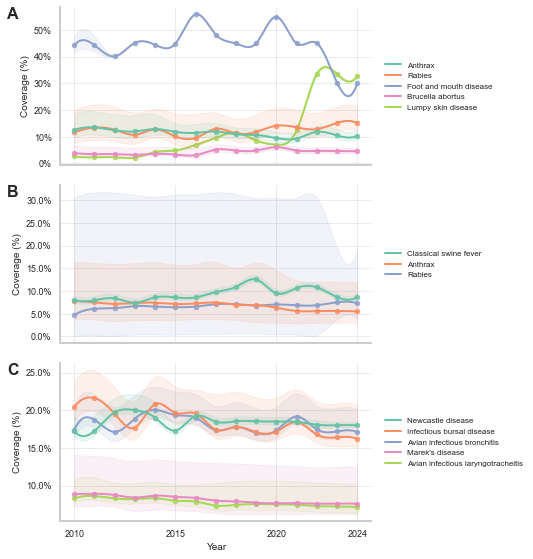

In [31]:
df_all = df_calculations_vacc.copy()
df_all["Unvaccinated"] = (df_all["latest pop"] - df_all["Number of Vaccinated Estimate"]).clip(lower=0)

colors = ['#66c2a5',  # teal
          '#fc8d62',  # coral
          '#8da0cb',  # light blue
          '#e78ac3',  # pale pink
          '#a6d854']  # light green

plt.rcParams["font.family"] = "Arial"
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=len(simplified_animal_diseases), ncols=1, figsize=(8, 8), sharex=True)
labels = ['A', 'B', 'C']  # Panel labels

for idx, (animal, diseases) in enumerate(simplified_animal_diseases.items()):
    ax = axes[idx]
    
    for i, disease in enumerate(diseases):
        print(f"{animal} : {disease}")
        
        # Filter data for the given disease and animal (ensure at-risk).
        if 'castle' not in disease:
            df_disease = df_all[
                (df_all["Disease"] == disease) &
                (df_all["Animal"] == animal) &
                (df_all['Number of Vaccinated Estimate'].notna()) &
                (df_all['Estimated (Scaled) Cases'].notna())
            ]
        else:
            df_disease = df_all[
                (df_all["Disease"] == disease) &
                (df_all["Animal"] == animal) &
                (df_all['Number of Vaccinated Estimate'].notna())
            ]
        
        # Calculate coverage and confidence bounds (only for years ≥ 2010) (less samples, lower quality before 2010)
        coverage_per_year = {}
        coverage_per_year_lower = {}
        coverage_per_year_upper = {}
        for year in np.unique(df_disease['Year']):
            if year >= 2010:
                df_year = df_disease[df_disease['Year'] == year]
                total_pop = df_year['latest pop'].sum()
                if total_pop > 0:
                    coverage = df_year['Number of Vaccinated Estimate'].sum() / total_pop
                    coverage_lower = df_year['Number of Vaccinated Lower'].sum() / total_pop
                    coverage_upper = df_year['Number of Vaccinated Upper'].sum() / total_pop
                else:
                    coverage, coverage_lower, coverage_upper = np.nan, np.nan, np.nan
                coverage_per_year[year] = coverage
                coverage_per_year_lower[year] = coverage_lower
                coverage_per_year_upper[year] = coverage_upper
                
        years_sorted = np.array(sorted(coverage_per_year.keys()))
        coverage_vals = np.array([coverage_per_year[yr] for yr in years_sorted])
        lower_vals = np.array([coverage_per_year_lower[yr] for yr in years_sorted])
        upper_vals = np.array([coverage_per_year_upper[yr] for yr in years_sorted])
        
        # Smooth curves with interpolation
        interpolated_years = np.linspace(years_sorted.min(), years_sorted.max(), 500)
        try:
            spline = make_interp_spline(years_sorted, coverage_vals, k=3)
            smoothed_coverage = spline(interpolated_years)
            lower_spline = make_interp_spline(years_sorted, lower_vals, k=3)
            smoothed_lower = lower_spline(interpolated_years)
            upper_spline = make_interp_spline(years_sorted, upper_vals, k=3)
            smoothed_upper = upper_spline(interpolated_years)
        except Exception as e:
            interpolated_years = years_sorted
            smoothed_coverage = coverage_vals
            smoothed_lower = lower_vals
            smoothed_upper = upper_vals
        
        color = colors[i % len(colors)]
        zorder_conf = 10 - i
        zorder_line = 11 - i
        zorder_scatter = 12 - i
        
        # Plot the confidence interval as a semi-transparent filled area
        ax.fill_between(interpolated_years, smoothed_lower, smoothed_upper, color=color, alpha=0.12, zorder=zorder_conf)
        disease_label = (disease.replace(' (Inf. with)', '')
                                  .replace(' (Gumboro disease)', '')
                                  .replace(' virus', '')
                                  .replace(' (-2011)', ''))
        ax.plot(interpolated_years, smoothed_coverage, label=disease_label, color=color, linewidth=2, zorder=zorder_line)
        ax.scatter(years_sorted, coverage_vals, color=color, marker='o', alpha=0.8, s=20, zorder=zorder_scatter)
    
    ax.set_ylabel("Coverage (%)", fontsize=10)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.tick_params(axis='y', labelsize=9)
    
    min_year = int(years_sorted.min())
    max_year = int(years_sorted.max())
    tick_years = list(np.arange(min_year, max_year + 1, 5))
    if max_year not in tick_years:
        tick_years.append(max_year)
    tick_years = sorted(tick_years)
    ax.set_xticks(tick_years)
    ax.set_xticklabels(tick_years, fontsize=9, rotation=0)
    
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                       ncol=1, fontsize=8, frameon=True,
                       facecolor='white', edgecolor='none', framealpha=0.55)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.17, 1, labels[idx], transform=ax.transAxes, fontsize=16, fontweight='bold',
            va='top', ha='left')

plt.xlabel("Year", fontsize=10)
plt.tight_layout()

fig.savefig('Estimated_Vaccination_Coverage_Over_Time_(Top_Targeted_Diseases).svg',
            format='svg', bbox_inches='tight', facecolor='white')
fig.savefig('Estimated_Vaccination_Coverage_Over_Time_(Top_Targeted_Diseases).png',
            format='png', bbox_inches='tight', dpi=600, facecolor='white')

plt.show()


In [32]:
top_3_disease={'Cattle': ['Lumpy skin disease virus (Inf. with)',
  'Echinococcosis/hydatidosis',
  'Foot and mouth disease virus (Inf. with)'],
 'Poultry': ['Newcastle disease (velogenic)',
  'Avian infectious bronchitis',
  'Low pathogenic avian influenza (poultry) (2006-2021)'],
 'Pigs': ['African swine fever virus (Inf. with)',
  'Echinococcosis/hydatidosis',
  'Porcine reproductive and respiratory syndrome virus (Inf. with)']}

Cattle : Lumpy skin disease virus (Inf. with)
Cattle : Echinococcosis/hydatidosis
Cattle : Foot and mouth disease virus (Inf. with)
Poultry : Newcastle disease (velogenic)
Poultry : Avian infectious bronchitis
Poultry : Low pathogenic avian influenza (poultry) (2006-2021)
Pigs : African swine fever virus (Inf. with)
Pigs : Echinococcosis/hydatidosis
Pigs : Porcine reproductive and respiratory syndrome virus (Inf. with)


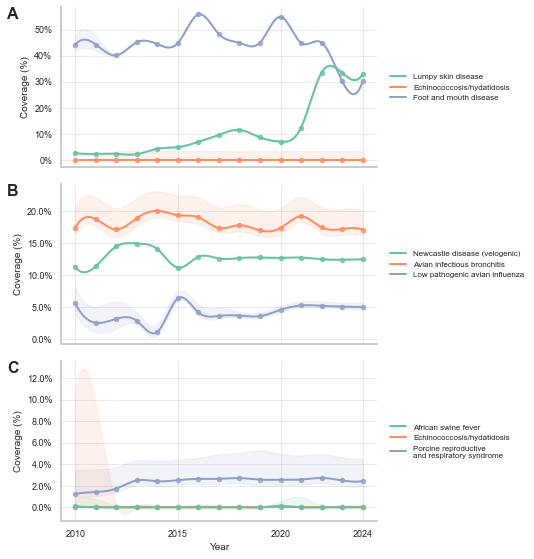

In [33]:
df_all = df_calculations_vacc.copy()
df_all["Unvaccinated"] = (df_all["latest pop"] - df_all["Number of Vaccinated Estimate"]).clip(lower=0)

colors = ['#66c2a5',  # teal
          '#fc8d62',  # coral
          '#8da0cb',  # light blue
          '#e78ac3',  # pale pink
          '#a6d854']  # light green

plt.rcParams["font.family"] = "Arial"
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=len(top_3_disease), ncols=1, figsize=(8, 8), sharex=True)
labels = ['A', 'B', 'C']  # Panel labels

for idx, (animal, diseases) in enumerate(top_3_disease.items()):
    ax = axes[idx]
    
    for i, disease in enumerate(diseases):
        print(f"{animal} : {disease}")
        
        # Filter data for the given disease and animal (ensure at-risk).
        if 'castle' not in disease:
            df_disease = df_all[
                (df_all["Disease"] == disease) &
                (df_all["Animal"] == animal) &
                (df_all['Number of Vaccinated Estimate'].notna()) &
                (df_all['Estimated (Scaled) Cases'].notna())
            ]
        else:
            df_disease = df_all[
                (df_all["Disease"] == disease) &
                (df_all["Animal"] == animal) &
                (df_all['Number of Vaccinated Estimate'].notna())
            ]
        
        # Calculate coverage and confidence bounds (only for years ≥ 2010) (less samples, lower quality before 2010)
        coverage_per_year = {}
        coverage_per_year_lower = {}
        coverage_per_year_upper = {}
        for year in np.unique(df_disease['Year']):
            if year >= 2010:
                df_year = df_disease[df_disease['Year'] == year]
                total_pop = df_year['latest pop'].sum()
                if total_pop > 0:
                    coverage = df_year['Number of Vaccinated Estimate'].sum() / total_pop
                    coverage_lower = df_year['Number of Vaccinated Lower'].sum() / total_pop
                    coverage_upper = df_year['Number of Vaccinated Upper'].sum() / total_pop
                else:
                    coverage, coverage_lower, coverage_upper = np.nan, np.nan, np.nan
                coverage_per_year[year] = coverage
                coverage_per_year_lower[year] = coverage_lower
                coverage_per_year_upper[year] = coverage_upper
        
        years_sorted = np.array(sorted(coverage_per_year.keys()))
        coverage_vals = np.array([coverage_per_year[yr] for yr in years_sorted])
        lower_vals = np.array([coverage_per_year_lower[yr] for yr in years_sorted])
        upper_vals = np.array([coverage_per_year_upper[yr] for yr in years_sorted])
        
        # Smooth curves with interpolation
        interpolated_years = np.linspace(years_sorted.min(), years_sorted.max(), 500)
        try:
            spline = make_interp_spline(years_sorted, coverage_vals, k=3)
            smoothed_coverage = spline(interpolated_years)
            lower_spline = make_interp_spline(years_sorted, lower_vals, k=3)
            smoothed_lower = lower_spline(interpolated_years)
            upper_spline = make_interp_spline(years_sorted, upper_vals, k=3)
            smoothed_upper = upper_spline(interpolated_years)
        except Exception as e:
            interpolated_years = years_sorted
            smoothed_coverage = coverage_vals
            smoothed_lower = lower_vals
            smoothed_upper = upper_vals
        
        color = colors[i % len(colors)]
        zorder_conf = 10 - i
        zorder_line = 11 - i
        zorder_scatter = 12 - i
        
        #Plot the confidence interval as a semi-transparent filled area
        ax.fill_between(interpolated_years, smoothed_lower, smoothed_upper, color=color, alpha=0.12, zorder=zorder_conf)
        #Plot the smoothed coverage line
        disease_label = disease.replace(' (Inf. with)','').replace(' (Gumboro disease)','').replace(' virus','').replace(' (-2011)','')
        disease_label=disease_label.replace(' (poultry) (2006-2021)','')
        if 'respiratory syndrome' in disease_label:
            disease_label= 'Porcine reproductive\nand respiratory syndrome'
        ax.plot(interpolated_years, smoothed_coverage, label=disease_label, color=color, linewidth=2, zorder=zorder_line)
        #Plot the original data points
        ax.scatter(years_sorted, coverage_vals, color=color, marker='o', alpha=0.8, zorder=zorder_scatter, s=20)
    
    ax.set_ylabel("Coverage (%)", fontsize=10)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.tick_params(axis='y', labelsize=9)
    
    min_year = int(years_sorted.min())
    max_year = int(years_sorted.max())
    tick_years = list(np.arange(min_year, max_year + 1, 5))
    if max_year not in tick_years:
        tick_years.append(max_year)
    tick_years = sorted(tick_years)
    ax.set_xticks(tick_years)
    ax.set_xticklabels(tick_years, fontsize=9, rotation=0)
    
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                       ncol=1, fontsize=8, frameon=True,
                       facecolor='white', edgecolor='none', framealpha=0.55)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.17, 1, labels[idx], transform=ax.transAxes, fontsize=16, fontweight='bold',
            va='top', ha='left')

plt.xlabel("Year", fontsize=10)
plt.tight_layout()

fig.savefig('Estimated_Vaccination_Coverage_Over_Time_(Top_3_Reported_Diseases).svg',
            format='svg', bbox_inches='tight', facecolor='white')
fig.savefig('Estimated_Vaccination_Coverage_Over_Time_(Top_3_Reported_Diseases).png',
            format='png', bbox_inches='tight', dpi=600, facecolor='white')

plt.show()


In [34]:
np.sum(df_incidence[(df_incidence['Disease'].str.contains('Lumpy sk'))&(df_incidence['Year']==2024)]['Aggregate of Latest Reported Cases (up to Year)'])

4110581.0

In [35]:
np.sum(df_calculations_cases[(df_calculations_cases['Disease'].str.contains('Lumpy sk'))]['Aggregate of Latest Reported Cases (up to Year)'])

13692636.0

In [36]:
chickens = []
pigs = []
cows = []
results = []  

for animal, disease in zip(animals[0:10] + animals[14:17], vaccines[0:10] + vaccines[14:17]):
    
    if 'Newcastle' in disease:
        disease = 'Newcastle disease (velogenic)'
        
    if animal == 'Swine':
        animal = 'Pigs'
    
    #print(animal, disease, ':')
    
    df_analyze = df_calculations_cases[(df_calculations_cases['Animal'] == animal) & (df_calculations_cases['Disease'] == disease)]
    df_analyze=df_analyze[df_analyze['Year']==2024]
    df_analyze = df_analyze[df_analyze.loc[:, ['Aggregate of Latest Reported Cases (up to Year)']].notna().all(1)]
    
    cases = sum(df_analyze['Aggregate of Latest Reported Cases (up to Year)'].values)
    
    # Append to lists for sorting
    if animal == 'Cattle':
        cows.append((disease, cases))
    elif animal == 'Poultry':
        chickens.append((disease, cases))
    else:
        pigs.append((disease, cases))

    results.append((animal, disease, cases))
   #print(int(cases))

cows = sorted(cows, key=lambda x: x[1], reverse=True)  
pigs = sorted(pigs, key=lambda x: x[1], reverse=True)  
chickens = sorted(chickens, key=lambda x: x[1], reverse=True)  

sorted_results = [('Cattle', disease, cases) for disease, cases in cows] + \
                 [('Pigs', disease, cases) for disease, cases in pigs] + \
                 [('Poultry', disease, cases) for disease, cases in chickens]

print("\nSorted Cases by Animal and Disease (Descending Order):")
for animal, disease, cases in sorted_results:
    print(f"{animal}: {disease} - {int(cases)}")



Sorted Cases by Animal and Disease (Descending Order):
Cattle: Lumpy skin disease virus (Inf. with) - 4110581
Cattle: Foot and mouth disease virus (Inf. with) - 929844
Cattle: Brucella abortus (Inf. with) - 209105
Cattle: Anthrax - 12344
Cattle: Rabies virus (Inf. with) - 12031
Pigs: Classical swine fever virus (Inf. with) - 174670
Pigs: Rabies virus (Inf. with) - 464
Pigs: Anthrax - 412
Poultry: Newcastle disease (velogenic) - 160212744
Poultry: Avian infectious bronchitis - 119004100
Poultry: Infectious bursal disease (Gumboro disease) - 12396113
Poultry: Avian infectious laryngotracheitis - 8510946
Poultry: Marek's disease (-2011) - 621784


In [37]:
chickens = []
pigs = []
cows = []
results = []  

for animal, disease in zip(animals[0:10] + animals[14:17], vaccines[0:10] + vaccines[14:17]):
    
    if 'Newcastle' in disease:
        disease = 'Newcastle disease (velogenic)'
        
    if animal == 'Swine':
        animal = 'Pigs'
    
    #print(animal, disease, ':')
    
    df_analyze = df_calculations_cases[(df_calculations_cases['Animal'] == animal) & (df_calculations_cases['Disease'] == disease)]
    df_analyze=df_analyze[df_analyze['Year']==2024]
    df_analyze = df_analyze[df_analyze.loc[:, ['Estimated (Scaled) Cases']].notna().all(1)]
    
    cases = sum(df_analyze['Estimated (Scaled) Cases'].values)
    
    # Append to appropriate lists for sorting
    if animal == 'Cattle':
        cows.append((disease, cases))
    elif animal == 'Poultry':
        chickens.append((disease, cases))
    else:
        pigs.append((disease, cases))

    results.append((animal, disease, cases))
   #print(int(cases))

cows = sorted(cows, key=lambda x: x[1], reverse=True)  
pigs = sorted(pigs, key=lambda x: x[1], reverse=True) 
chickens = sorted(chickens, key=lambda x: x[1], reverse=True)  

sorted_results = [('Cattle', disease, cases) for disease, cases in cows] + \
                 [('Pigs', disease, cases) for disease, cases in pigs] + \
                 [('Poultry', disease, cases) for disease, cases in chickens]

print("\nSorted Estimated (Scaled) Cases by Animal and Disease (Descending Order):")
for animal, disease, cases in sorted_results:
    print(f"{animal}: {disease} - {int(cases)}")



Sorted Estimated (Scaled) Cases by Animal and Disease (Descending Order):
Cattle: Lumpy skin disease virus (Inf. with) - 4146889
Cattle: Foot and mouth disease virus (Inf. with) - 1057692
Cattle: Brucella abortus (Inf. with) - 292855
Cattle: Anthrax - 39184
Cattle: Rabies virus (Inf. with) - 15664
Pigs: Classical swine fever virus (Inf. with) - 212900
Pigs: Anthrax - 2901
Pigs: Rabies virus (Inf. with) - 1116
Poultry: Newcastle disease (velogenic) - 172948544
Poultry: Avian infectious bronchitis - 134608847
Poultry: Infectious bursal disease (Gumboro disease) - 39636594
Poultry: Avian infectious laryngotracheitis - 21478313
Poultry: Marek's disease (-2011) - 4040582
